# Deriving a zeroth order slice mask

When observing an external flat source the MRS slices are illuminated uniformly. Each projected corresponds to a mask placed after the image slicer. Each slit in the mask effectively acts as an entrance slit, which comes before the diffraction grating. Diffraction effects around the slit will cause a smooth variation of the transmission around the slit. As a result the illumination on the detector deviates from looking like a box function. Instead the box function is convolved by a Gaussian, resulting in rounded corners and a smoothely varying transmission. In this notebook we derive a detector slice mask based on the transmission minima.

In [17]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Let us find the slice transmission minima in every row of the detector, in each spectral band. We use the MTS blackbody observations for this, acquired during FM testing at RAL. For bands 1A up to 4B we use the 800K BB measurements, and for band 4C we use the 400K BB measurements (higher SNR at furthest wavelengths).

In [1]:
import funcs
import mrsobs

import numpy as np
from astropy.convolution import convolve,Box2DKernel
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

In [3]:
# load objects if already available
sliceMap_0percent   = funcs.load_obj('sliceMap_0percent')
sliceEdges_0percent = funcs.load_obj('sliceEdges_0percent')

In [4]:
# Define the ids of the individual slices
sliceid1=[111,121,110,120,109,119,108,118,107,117,106,116,105,115,104,114,103,113,102,112,101]
sliceid2=[201,210,202,211,203,212,204,213,205,214,206,215,207,216,208,217,209]
sliceid3=[316,308,315,307,314,306,313,305,312,304,311,303,310,302,309,301]
sliceid4=[412,406,411,405,410,404,409,403,408,402,407,401]

# # Initialize placeholder
# sliceMap_0percent   = {}
# sliceEdges_0percent = {}

In [5]:
sliceMap,alphaMap,sci_signal = {},{},{}
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    # Load slice mask extension of distortion map
    d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
    sliceMap[band] = d2cMaps['sliceMap']
    alphaMap[band] = d2cMaps['alphaMap']
    
    # Load fringe correction map and replace NaNs by 1
    fringe_img = funcs.get_cdps(band,cdpDir,output='img')[0]
    fringe_img[np.isnan(fringe_img)] = 1
    
    # Load external extended source signal
    if band == '4C':
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K',output='img')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img
    else:
        source_signal,bkg_signal = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K',output='img')
        sci_signal[band] = (source_signal-bkg_signal)/fringe_img 

In [12]:
# Derive slice map - channel 1
band = '1A' # '1A','1B','1C'

sliceMap_0percent[band] = np.zeros((1024,1032))
sliceEdges_0percent[band] = np.zeros((1024,1032))
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512], thres=0., min_dist=20)
    if (peaks[-1]<500):
        peaks = np.insert(peaks,len(peaks),511)
    if (len(peaks) != len(sliceid1)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,:512][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,:512])]), thres=0., min_dist=20)
    peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
    peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))
    
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,peaks[i]:peaks[i+1]] = sliceid1[i]
    if (peaks[0]<5) & (row!=1):
        sliceMap_0percent[band][row,:512] = sliceMap_0percent[band][row-1,:512]
    
    sliceEdges_0percent[band][row,peaks] = 1

sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


<IPython.core.display.Javascript object>


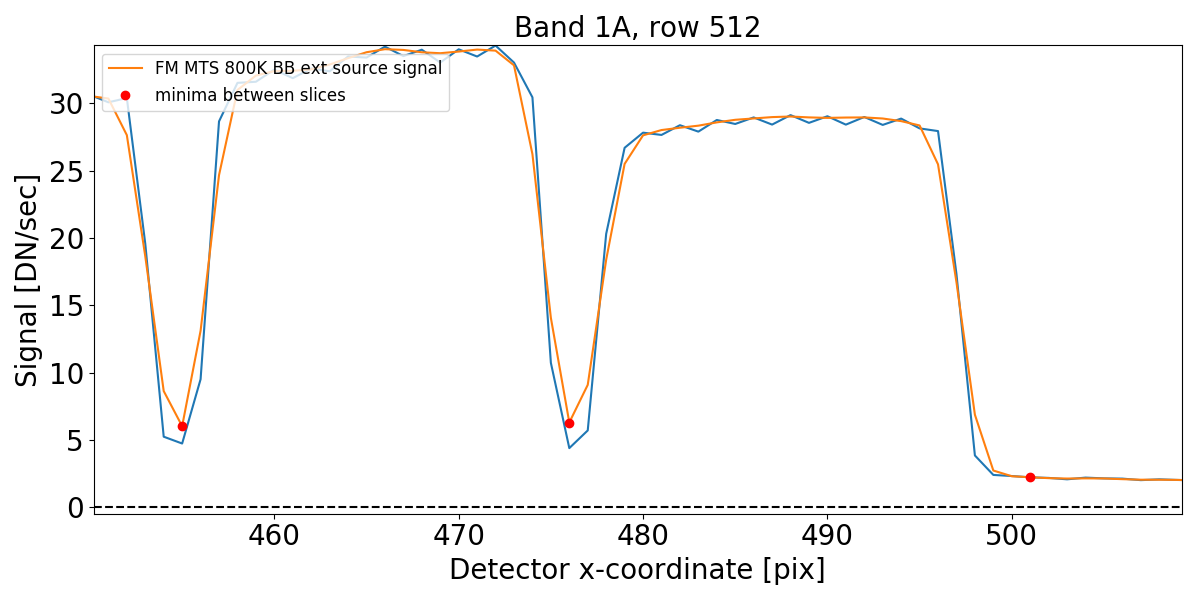

In [14]:
# Test single row - channel 1
band = '1A'
row  = 512

peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512], thres=0., min_dist=20)
if (len(peaks) == len(sliceid1)) & (peaks[-1]<500):
    peaks = np.insert(peaks,len(peaks),511)
if len(peaks) != len(sliceid1)+1:
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,:512]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,:512][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,:512])]), thres=0., min_dist=20)

peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))

plt.figure(figsize=(12,6))
plt.title('Band {}, row {}'.format(band,row),fontsize=20)
plt.plot(sci_signal[band][row,:512])
plt.plot(convolve(sci_signal[band],Box2DKernel(2))[row,:512],label='FM MTS 800K BB ext source signal')
plt.plot(peaks,convolve(sci_signal[band],Box2DKernel(2))[row,:512][peaks],'ro',label='minima between slices')
plt.hlines(0,0,512,linestyle='dashed')
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.legend(loc='upper left',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [6]:
# Derive slice map - channel 2
band = '2A' # '2A','2B','2C'

sliceMap_0percent[band] = np.zeros((1024,1032))
sliceEdges_0percent[band] = np.zeros((1024,1032))

sci_signal_noNeg = sci_signal[band].copy()
sci_signal_noNeg[sci_signal_noNeg<0] = 0
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(2))[row,512:1011], thres=0., min_dist=20)
    if (512+peaks[-1]<985):
        peaks = np.insert(peaks,len(peaks),1010-512)
    if (512+peaks[0]>530):
        peaks = np.insert(peaks,0,512-512)
    if (len(peaks) != len(sliceid2)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(2))[row,512:1011]-np.min(-convolve(sci_signal_noNeg,Box2DKernel(2))[row,512:1011][~np.isnan(-convolve(sci_signal_noNeg,Box2DKernel(2))[row,512:1011])]), thres=0., min_dist=20)
        
    peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
    peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))
    if (peaks[0]<0) & (row!=1):
        print row
        sliceMap_0percent[band][row,512:1011] = sliceMap_0percent[band][row-1,512:1011]
    
    sliceEdges_0percent[band][row,512+peaks] = 1
    
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,512+peaks[i]:512+peaks[i+1]] = sliceid2[i]
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


<IPython.core.display.Javascript object>


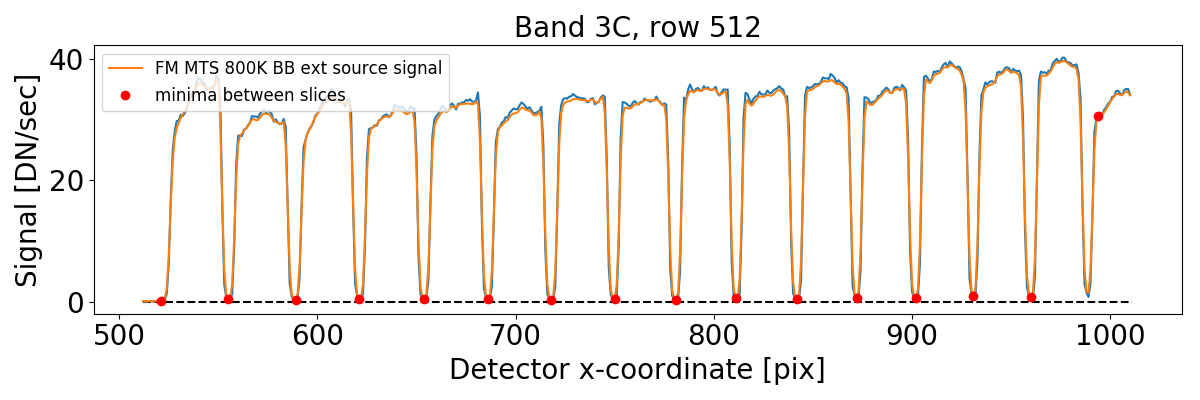

In [8]:
# Test single row - channel 2
band = '2A'
row  = 512

test_img = sci_signal[band].copy()
test_img[test_img<0] = 0
peaks = funcs.find_peaks(-convolve(test_img,Box2DKernel(2))[row,512:1011], thres=0., min_dist=20)
if (512+peaks[-1]<985):
    peaks = np.insert(peaks,len(peaks),1010-512)
if (512+peaks[0]>530):
    peaks = np.insert(peaks,0,0)
peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))

plt.figure(figsize=(12,4))
plt.title('Band {}, row {}'.format(band,row),fontsize=20)
plt.plot(512+np.arange(len(test_img[row,512:1011])),test_img[row,512:1011])
plt.plot(512+np.arange(len(test_img[row,512:1011])),convolve(test_img,Box2DKernel(2))[row,512:1011],label='FM MTS 800K BB ext source signal')
plt.plot(512+peaks,convolve(test_img,Box2DKernel(2))[row,512:1011][peaks],'ro',label='minima between slices')
plt.hlines(0,512,1011,linestyle='dashed')
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.legend(loc='upper left',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [ ]:
# Derive slice map - channel 3
band = '3A' # '3A','3B','3C'

sliceMap_0percent[band] = np.zeros((1024,1032))
sliceEdges_0percent[band] = np.zeros((1024,1032))

for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:], thres=0., min_dist=25)
    if (512+peaks[0]>530):
        peaks = np.insert(peaks,0,512-512)
    if (len(peaks) != len(sliceid3)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,512:][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,512:])]), thres=0., min_dist=25)
        
    peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
    peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))
    
    if (peaks[0]<0) & (row!=1):
        peaks[0] = 0
    
    sliceEdges_0percent[band][row,512+peaks] = 1
    
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,512+peaks[i]:512+peaks[i+1]] = sliceid3[i]
    
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

<IPython.core.display.Javascript object>


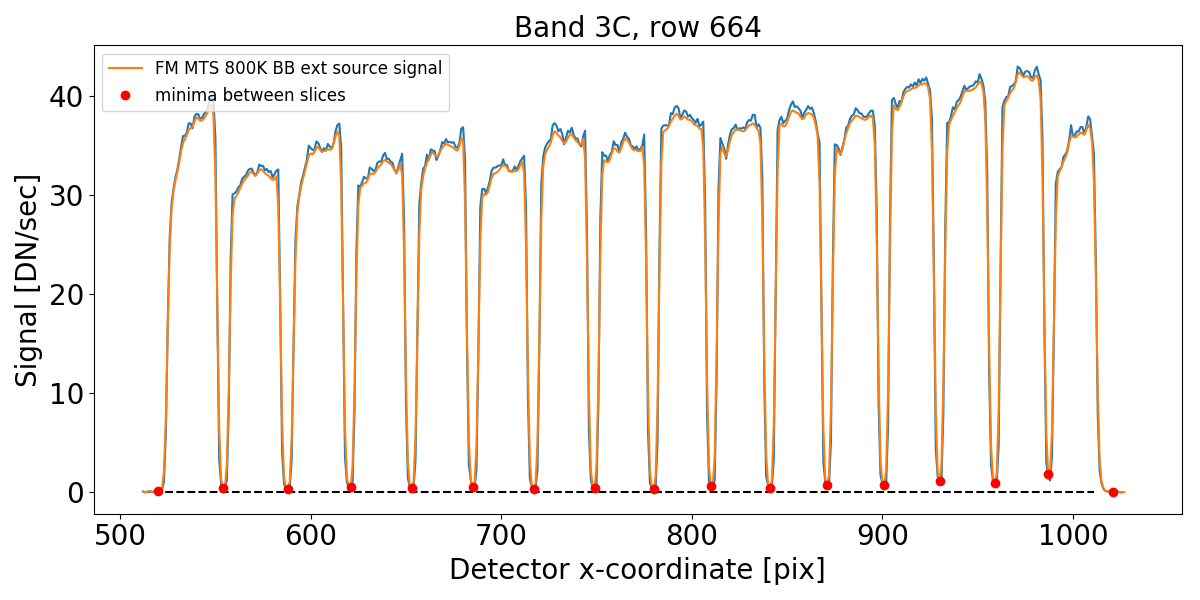

In [12]:
# Test single row - channel 3
band = '3C'
row  = 664

peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:], thres=0., min_dist=25)
if (512+peaks[0]>530):
    peaks = np.insert(peaks,0,512-512)
if (len(peaks) != len(sliceid3)+1) :
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(2))[row,512:]-np.min(-convolve(sci_signal[band],Box2DKernel(2))[row,512:][~np.isnan(-convolve(sci_signal[band],Box2DKernel(2))[row,512:])]), thres=0., min_dist=25)

peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))

plt.figure(figsize=(12,6))
plt.title('Band {}, row {}'.format(band,row),fontsize=20)
plt.plot(512+np.arange(len(sci_signal[band][row,512:])),sci_signal[band][row,512:])
plt.plot(512+np.arange(len(sci_signal[band][row,512:])),convolve(sci_signal[band],Box2DKernel(2))[row,512:],label='FM MTS 800K BB ext source signal')
plt.plot(512+peaks,convolve(sci_signal[band],Box2DKernel(2))[row,512:][peaks],'ro',label='minima between slices')
plt.hlines(0,512,1011,linestyle='dashed')
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.legend(loc='upper left',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [ ]:
# Derive slice map - channel 4 band 4A and 4B
band = '4C' # '4A','4B'

sliceMap_0percent[band] = np.zeros((1024,1032))
sliceEdges_0percent[band] = np.zeros((1024,1032))

sci_signal_noNeg = sci_signal[band].copy()
# sci_signal_noNeg[sci_signal_noNeg<0] = 0
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480], thres=0., min_dist=30)
    
    if (len(peaks) != len(sliceid4)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480]-np.min(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480][~np.isnan(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)
    
    peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
    peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))
    
    sliceEdges_0percent[band][row,peaks] = 1
    
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,peaks[i]:peaks[i+1]] = sliceid4[i]
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

<IPython.core.display.Javascript object>


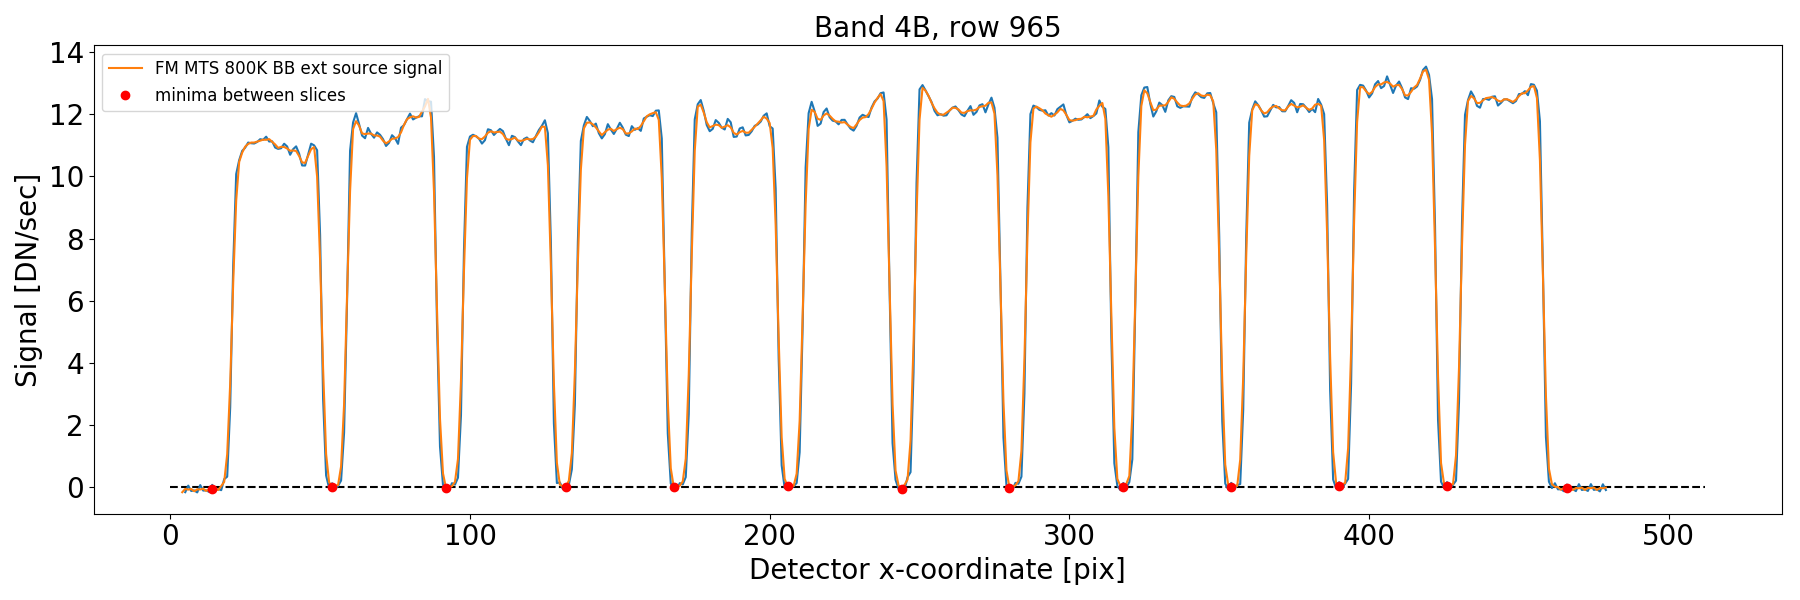

In [11]:
# Test single row - channel 4 band 4A and 4B
band = '4B'
row  = 965

sci_signal_noNeg = sci_signal[band].copy()
# sci_signal_noNeg[sci_signal_noNeg<0] = 0
peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480], thres=0., min_dist=30)
if (len(peaks) != len(sliceid4)+1) :
    peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480]-np.min(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480][~np.isnan(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)

peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))

plt.figure(figsize=(18,6))
plt.title('Band {}, row {}'.format(band,row),fontsize=20)
plt.plot(sci_signal_noNeg[row,:480])
plt.plot(convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480],label='FM MTS 800K BB ext source signal')
plt.plot(peaks,convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480][peaks],'ro',label='minima between slices')
plt.hlines(0,0,512,linestyle='dashed')
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.legend(loc='upper left',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [ ]:
# Derive slice map - channel 4 band 4C
band = '4C'

sliceMap_0percent[band]   = np.zeros((1024,1032))
sliceEdges_0percent[band] = np.zeros((1024,1032))

sci_signal_noNeg = sci_signal[band].copy()
sci_signal_noNeg[sci_signal_noNeg<0] = 0
for row in range(1,1023):
    if row%100 == 0:
        print 'Row {}'.format(row)
    peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480], thres=0., min_dist=30)
    if (len(peaks) != len(sliceid4)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480]-np.min(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480][~np.isnan(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)
    if (len(peaks) != len(sliceid4)+1) :
        peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(3))[row,:480]-np.min(-convolve(sci_signal[band],Box2DKernel(3))[row,:480][~np.isnan(-convolve(sci_signal[band],Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)
    
    peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
    peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))
    
    sliceEdges_0percent[band][row,peaks] = 1
    
    for i in range(len(peaks)-1):
        sliceMap_0percent[band][row,peaks[i]:peaks[i+1]] = sliceid4[i]
    
sliceMap_0percent[band][0,:]  = sliceMap_0percent[band][1,:].copy()
sliceMap_0percent[band][-1,:] = sliceMap_0percent[band][-2,:].copy()

<IPython.core.display.Javascript object>


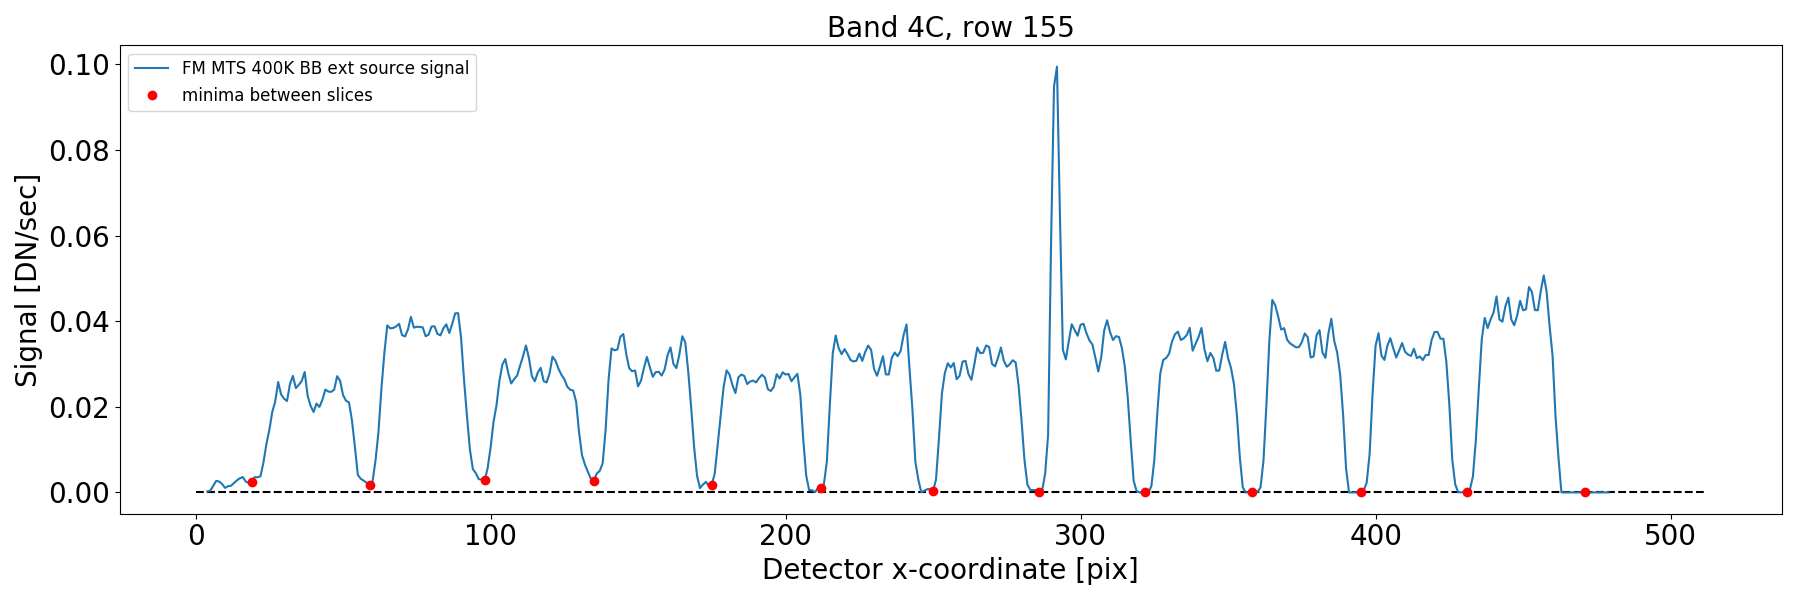

In [12]:
# Test single row - channel 4 band 4C -- Use 400K BB data!
band = '4C'
row  = 155

sci_signal_noNeg = sci_signal[band].copy()
sci_signal_noNeg[sci_signal_noNeg<0] = 0
peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480], thres=0., min_dist=30)
if len(peaks) != len(sliceid4)+1:
    peaks = funcs.find_peaks(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480]-np.min(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480][~np.isnan(-convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)
if (len(peaks) != len(sliceid4)+1) :
    peaks = funcs.find_peaks(-convolve(sci_signal[band],Box2DKernel(3))[row,:480]-np.min(-convolve(sci_signal[band],Box2DKernel(3))[row,:480][~np.isnan(-convolve(sci_signal[band],Box2DKernel(3))[row,:480])]), thres=0., min_dist=30)


peaks[0]  = peaks[1]-np.max(np.diff(peaks[1:-1]))
peaks[-1] = peaks[-2]+np.max(np.diff(peaks[1:-1]))

plt.figure(figsize=(18,6))
plt.title('Band {}, row {}'.format(band,row),fontsize=20)
plt.plot(convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480],label='FM MTS 400K BB ext source signal')
plt.plot(peaks,convolve(sci_signal_noNeg,Box2DKernel(3))[row,:480][peaks],'ro',label='minima between slices')
plt.hlines(0,0,512,linestyle='dashed')
plt.xlabel('Detector x-coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.legend(loc='upper left',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

Here we could plot a 2D map with the slice boundaries, but for a clearer illustration we "color" the spaces between the boundaries with the corresponding slice number. Such a plot is shown for band 1A below.

<IPython.core.display.Javascript object>


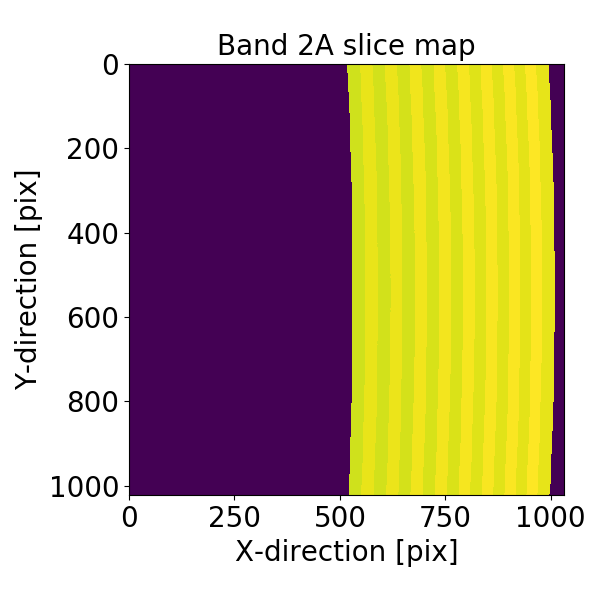

In [21]:
# plot result
band = '2A'
plt.figure(figsize=(6,6))
plt.title('Band {} slice map'.format(band),fontsize=20)
plt.imshow(sliceMap_0percent[band])
plt.xlabel('X-direction [pix]',fontsize=20)
plt.ylabel('Y-direction [pix]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [72]:
# save outputs
funcs.save_obj(sliceMap_0percent,'sliceMap_0percent')
funcs.save_obj(sliceEdges_0percent,'sliceEdges_0percent')